在Jupyter环境中运行，设置%matplotlib inline
已设置%matplotlib inline，图片将嵌入到输出中
使用默认数据路径: E:\github_project\data\creditcard.csv
数据加载完成，共284807行样本，31列特征


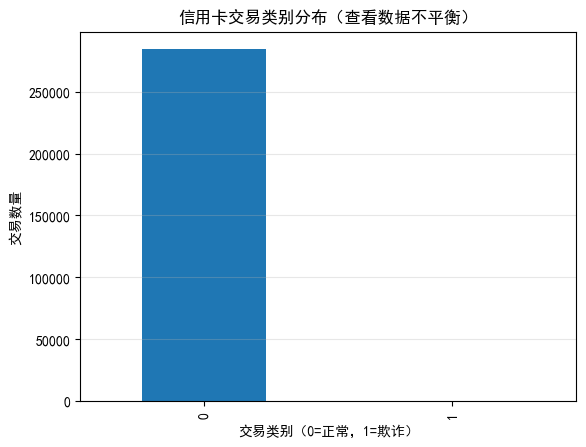

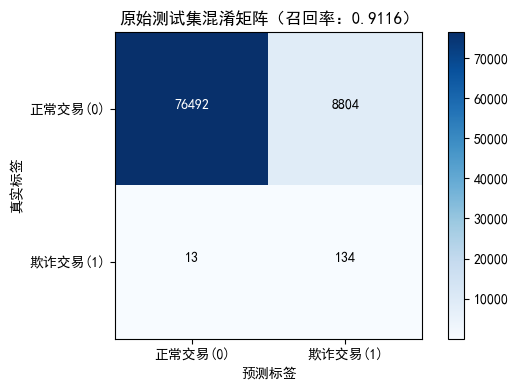

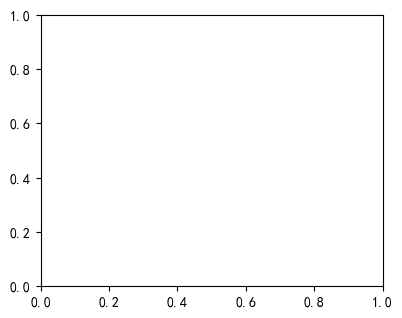

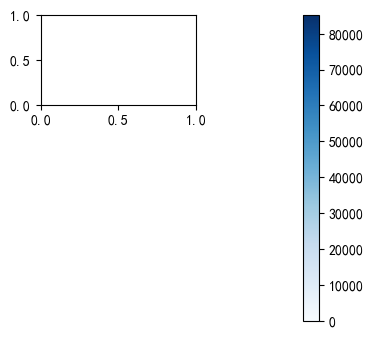

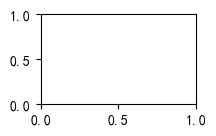

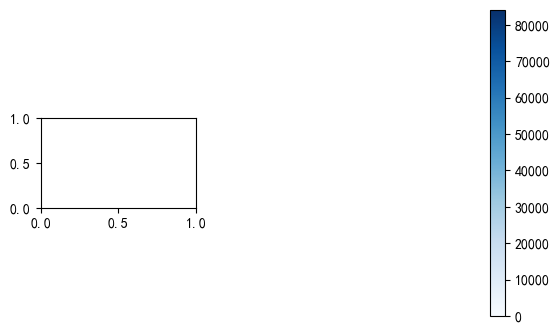

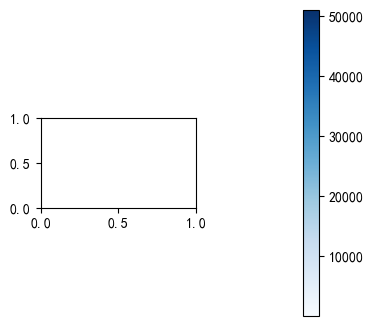

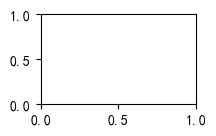

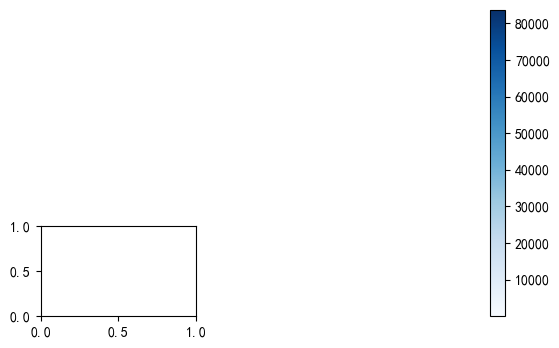

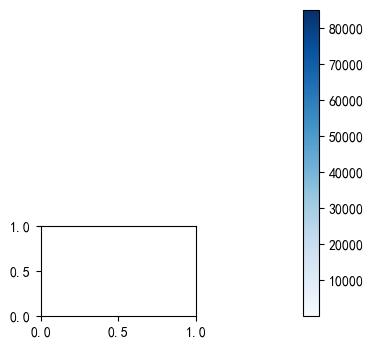

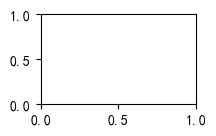

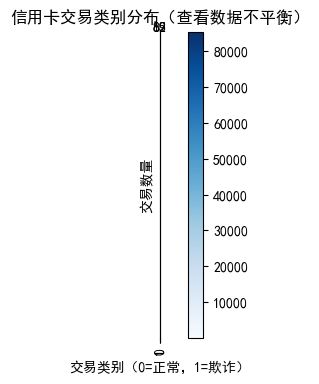

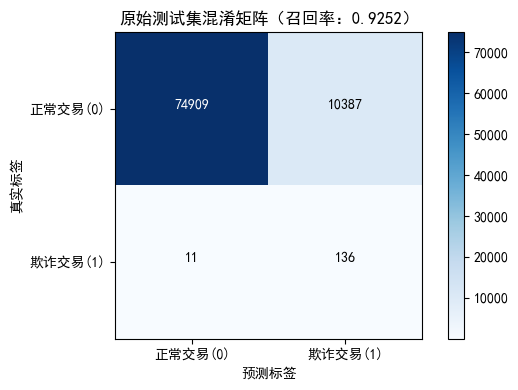

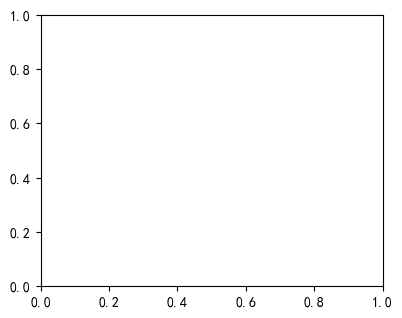

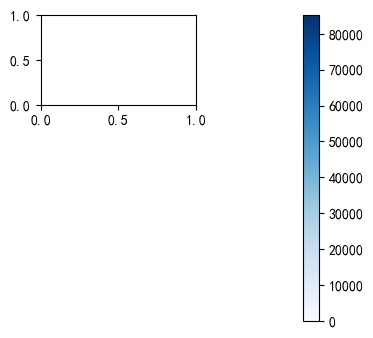

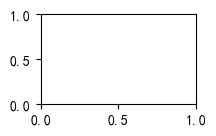

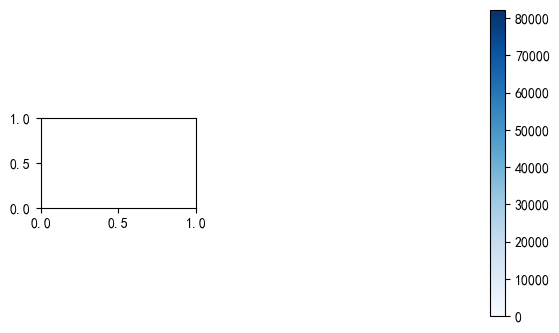

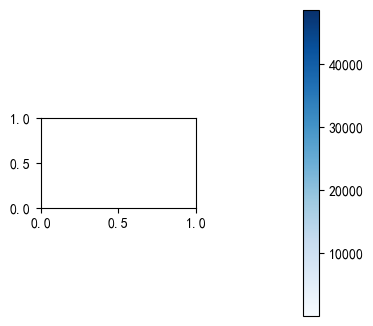

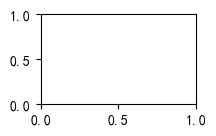

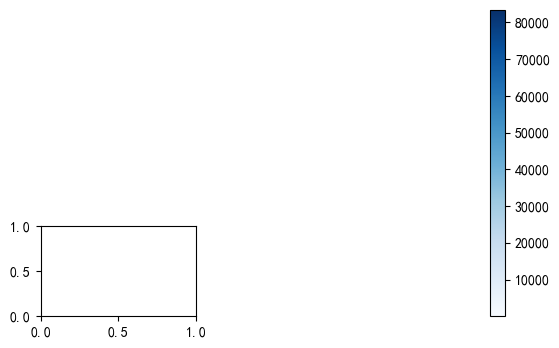

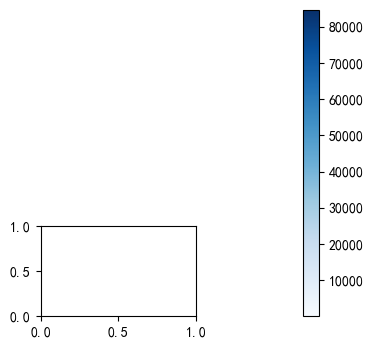

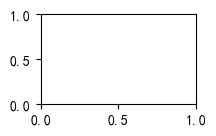

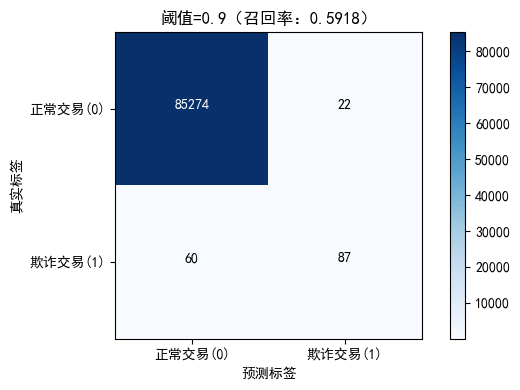

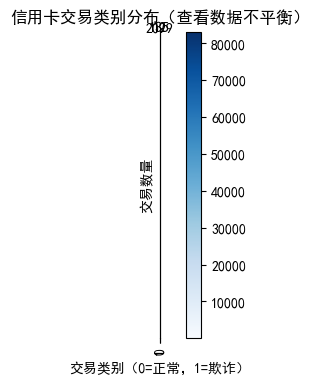

欺诈交易占比：0.1727%（数据严重不平衡）
预处理完成，特征矩阵形状：(284807, 29)，标签形状：(284807,)

原始数据集划分完成：训练集199364样本，测试集85443样本

===== 方案1：下采样训练模型 =====
X的索引范围: 1 - 284806
y的索引范围: 1 - 284806
欺诈样本数量: 345
正常样本数量: 199019
合并后索引数量: 690
合并后索引范围: 166 - 284504
有效索引数量: 690
无效索引数量: 0
下采样完成，总样本数：690，正常样本占比：50.0%（1:1平衡）

=== 开始交叉验证选择最佳参数 ===
参数C=0.01，5折平均召回率：0.5609
参数C=0.1，5折平均召回率：0.5377
参数C=1，5折平均召回率：0.5493
参数C=10，5折平均召回率：0.5464
参数C=100，5折平均召回率：0.5536
=== 交叉验证完成，最佳参数C：0.01 ===
模型训练完成（使用参数C=0.01）

【原始测试集评估】（模拟真实场景）


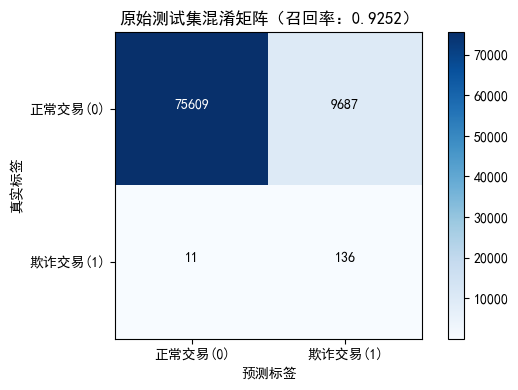

原始测试集召回率：0.9252（识别出136个欺诈，漏判11个欺诈）

【下采样模型阈值分析】

=== 开始阈值分析 ===


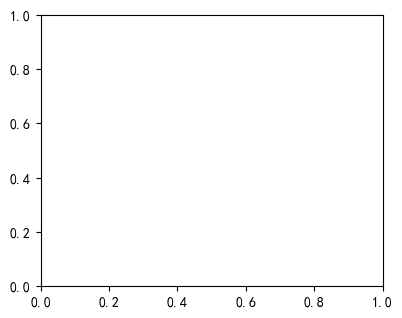

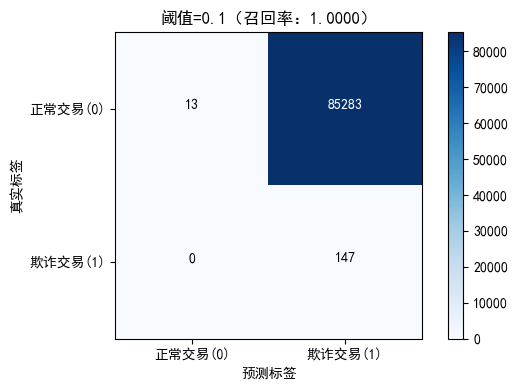

阈值=0.1，召回率：1.0000


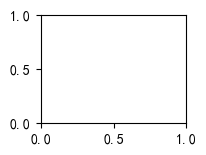

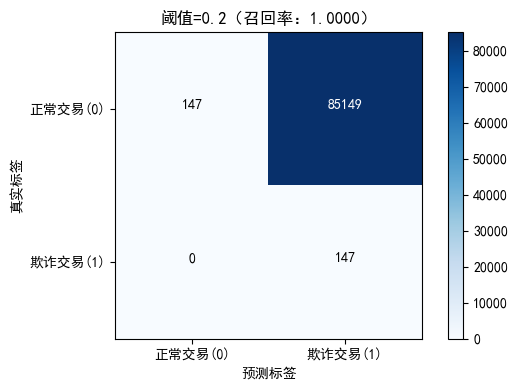

阈值=0.2，召回率：1.0000


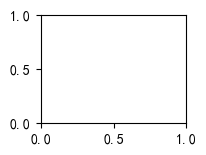

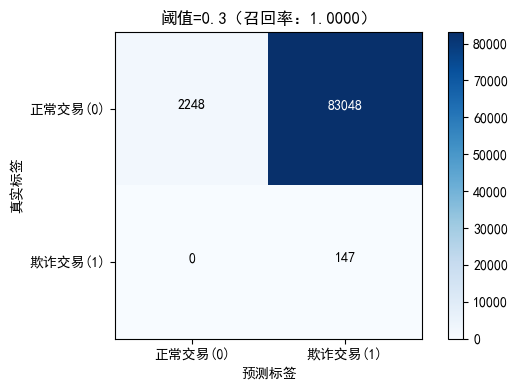

阈值=0.3，召回率：1.0000


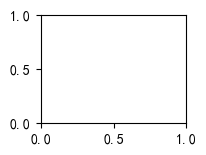

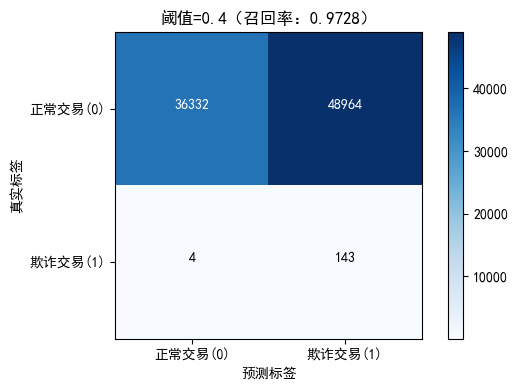

阈值=0.4，召回率：0.9728


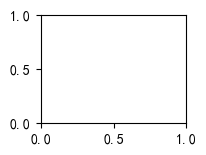

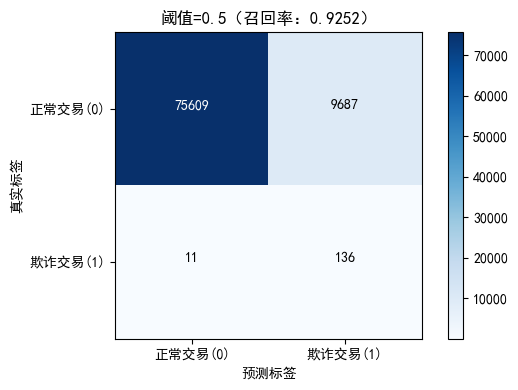

阈值=0.5，召回率：0.9252


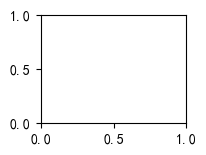

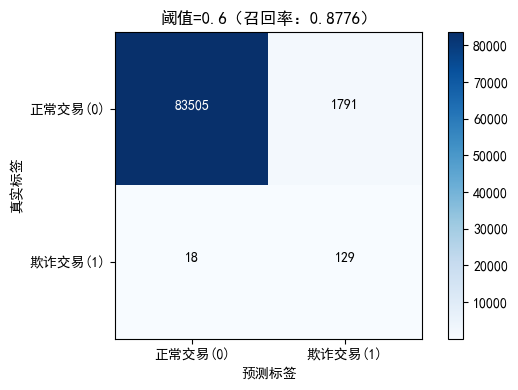

阈值=0.6，召回率：0.8776


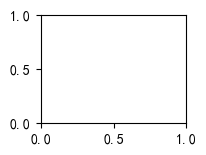

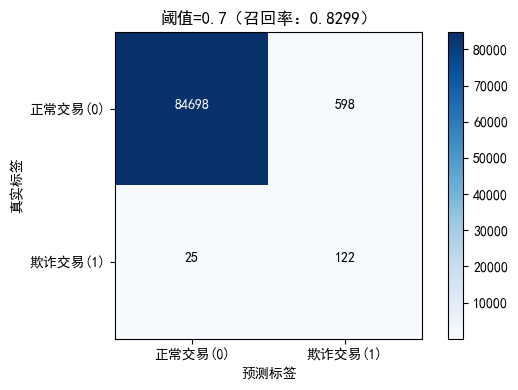

阈值=0.7，召回率：0.8299


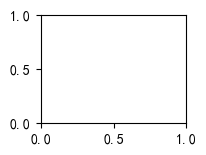

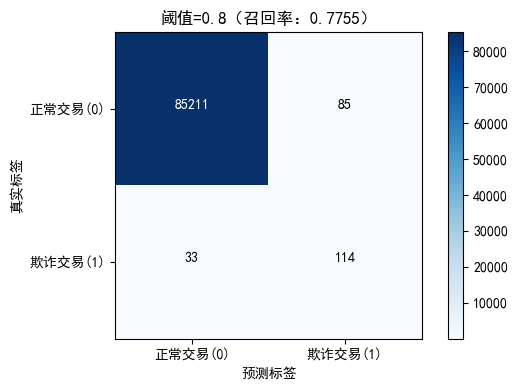

阈值=0.8，召回率：0.7755


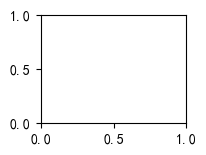

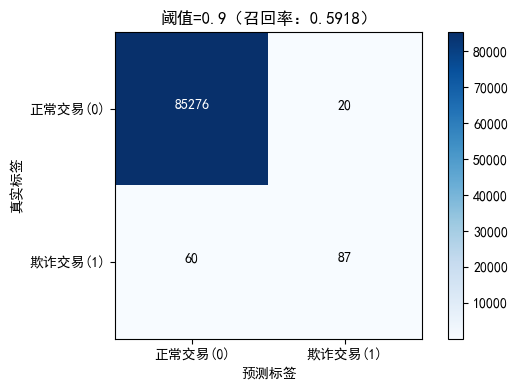

阈值=0.9，召回率：0.5918


<Figure size 640x480 with 0 Axes>


===== 方案2：SMOTE过采样训练模型 =====
SMOTE过采样完成，训练集总样本数：398038，欺诈/正常样本数：199019/199019（1:1平衡）

=== 开始交叉验证选择最佳参数 ===
参数C=0.01，5折平均召回率：0.9097
参数C=0.1，5折平均召回率：0.9121
参数C=1，5折平均召回率：0.9122
参数C=10，5折平均召回率：0.9123
参数C=100，5折平均召回率：0.9123
=== 交叉验证完成，最佳参数C：100.0 ===
模型训练完成（使用参数C=100.0）

【SMOTE模型原始测试集评估】


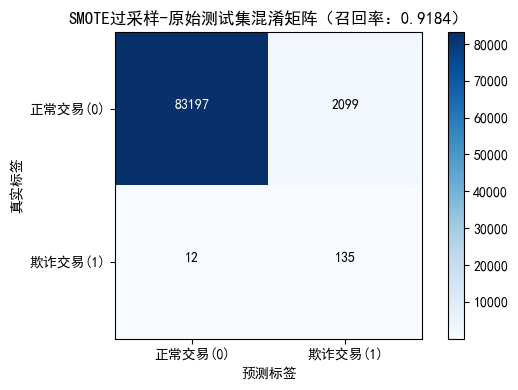

SMOTE过采样-原始测试集召回率：0.9184（识别出135个欺诈，漏判12个欺诈）


In [3]:
# 导入依赖库
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score
from imblearn.over_sampling import SMOTE
import itertools

# 设置matplotlib
import matplotlib
import matplotlib.pyplot as plt

# 忽略无关警告（避免输出干扰）
warnings.filterwarnings('ignore')
# 设置matplotlib中文字体（避免中文乱码）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


class DataProcessor:
    """
    数据处理类：负责数据加载、探索性分析、特征预处理
    核心职责：从文件读取数据→查看类别分布→标准化特征→分离特征与标签
    """
    def __init__(self, data_path):
        self.data_path = data_path  # 数据文件路径
        self.raw_data = None        # 原始数据
        self.processed_data = None  # 预处理后的数据

    def load_data(self):
        """加载CSV数据到内存"""
        self.raw_data = pd.read_csv(self.data_path)
        print(f"数据加载完成，共{self.raw_data.shape[0]}行样本，{self.raw_data.shape[1]}列特征")
        return self.raw_data

    def plot_class_distribution(self, target_col='Class'):
        """
        绘制目标类别分布直方图（查看数据不平衡程度）
        :param target_col: 目标列名（默认'Class'，1=欺诈，0=正常）
        """
        # 统计各类别数量
        class_counts = pd.value_counts(self.raw_data[target_col], sort=True).sort_index()
        # 绘制柱状图
        class_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
        plt.title('信用卡交易类别分布（查看数据不平衡）')
        plt.xlabel('交易类别（0=正常，1=欺诈）')
        plt.ylabel('交易数量')
        plt.grid(axis='y', alpha=0.3)
        plt.show()
        # 打印具体比例
        fraud_ratio = len(self.raw_data[self.raw_data[target_col]==1]) / len(self.raw_data) * 100
        print(f"欺诈交易占比：{fraud_ratio:.4f}%（数据严重不平衡）")

    def preprocess(self, drop_cols=['Time', 'Amount'], target_col='Class'):
        """
        数据预处理：标准化金额特征→删除无用列→分离特征与标签
        :param drop_cols: 需删除的无用特征列
        :param target_col: 目标列名
        :return: 预处理后的特征(X)、标签(y)
        """
        # 1. 复制原始数据（避免修改原数据）
        self.processed_data = self.raw_data.copy()
        
        # 2. 标准化金额特征（Amount）：消除尺度影响，生成新特征normAmount
        scaler = StandardScaler()
        self.processed_data['normAmount'] = scaler.fit_transform(
            self.processed_data['Amount'].values.reshape(-1, 1)
        )
        
        # 3. 删除无用列（Time无业务意义，Amount已被标准化替代）
        self.processed_data = self.processed_data.drop(drop_cols, axis=1)
        
        # 4. 分离特征（X）和标签（y）
        X = self.processed_data.iloc[:, self.processed_data.columns != target_col]
        y = self.processed_data[target_col]  # 返回Series而不是DataFrame，避免索引问题
        
        print(f"预处理完成，特征矩阵形状：{X.shape}，标签形状：{y.shape}")
        return X, y


class Sampler:
    """
    采样处理类：解决数据不平衡问题（下采样/SMOTE过采样）
    核心职责：从多数类抽样（下采样）或合成少数类样本（过采样）
    """
    @staticmethod
    def undersample(X, y, target_col='Class'):
        """
        下采样：从多数类（正常交易）中随机抽取与少数类（欺诈）等量的样本
        :param X: 原始特征矩阵
        :param y: 原始标签（Series类型）
        :return: 下采样后的特征(X_us)、标签(y_us)
        """
        # 调试信息
        print(f"X的索引范围: {X.index.min()} - {X.index.max()}")
        print(f"y的索引范围: {y.index.min()} - {y.index.max()}")
        
        # 1. 获取欺诈样本和正常样本的索引
        fraud_indices = np.array(y[y == 1].index)  # 欺诈样本索引
        normal_indices = np.array(y[y == 0].index)  # 正常样本索引
        fraud_count = len(fraud_indices)            # 欺诈样本数量
        
        print(f"欺诈样本数量: {fraud_count}")
        print(f"正常样本数量: {len(normal_indices)}")
        
        # 2. 从正常样本中随机抽取与欺诈样本等量的样本
        random_normal_indices = np.random.choice(
            normal_indices, size=fraud_count, replace=False  # replace=False避免重复抽样
        )
        
        # 3. 合并索引，生成下采样数据集
        undersample_indices = np.concatenate([fraud_indices, random_normal_indices])
        
        print(f"合并后索引数量: {len(undersample_indices)}")
        print(f"合并后索引范围: {min(undersample_indices)} - {max(undersample_indices)}")
        
        # 检查索引是否在X的范围内
        valid_indices = [i for i in undersample_indices if i in X.index]
        invalid_indices = [i for i in undersample_indices if i not in X.index]
        print(f"有效索引数量: {len(valid_indices)}")
        print(f"无效索引数量: {len(invalid_indices)}")
        
        # 使用有效的索引进行采样
        X_us = X.loc[valid_indices]
        y_us = y.loc[valid_indices]
        
        # 打印下采样结果
        normal_ratio_us = len(y_us[y_us == 0]) / len(y_us) * 100
        print(f"下采样完成，总样本数：{len(X_us)}，正常样本占比：{normal_ratio_us:.1f}%（1:1平衡）")
        return X_us, y_us

    @staticmethod
    def smote_oversample(X_train, y_train):
        """
        SMOTE过采样：在训练集上合成少数类（欺诈）样本（避免数据泄露，仅用于训练集）
        :param X_train: 训练集特征
        :param y_train: 训练集标签
        :return: 过采样后的特征(X_os)、标签(y_os)
        """
        # 初始化SMOTE采样器（random_state=0确保结果可复现）
        smote = SMOTE(random_state=0)
        X_os, y_os = smote.fit_resample(X_train, y_train.values.ravel())
        
        # 打印过采样结果
        fraud_count_os = len(y_os[y_os == 1])
        normal_count_os = len(y_os[y_os == 0])
        print(f"SMOTE过采样完成，训练集总样本数：{len(X_os)}，欺诈/正常样本数：{fraud_count_os}/{normal_count_os}（1:1平衡）")
        return pd.DataFrame(X_os), pd.DataFrame(y_os)


class ModelTrainer:
    """
    模型训练类：负责逻辑回归模型的训练、交叉验证选参
    核心职责：通过5折交叉验证选择最佳正则化参数→训练最终模型
    """
    def __init__(self):
        self.best_c = None  # 最佳正则化参数
        self.model = None   # 训练好的逻辑回归模型

    def select_best_param(self, X_train, y_train, c_range=[0.01, 0.1, 1, 10, 100], k_folds=5):
        """
        5折交叉验证选择最佳正则化参数C（控制模型复杂度，越小正则化越强）
        :param X_train: 训练集特征
        :param y_train: 训练集标签
        :param c_range: 参数C的候选列表
        :param k_folds: 交叉验证折数
        :return: 最佳参数best_c
        """
        kf = KFold(n_splits=k_folds, shuffle=False)  # 初始化5折交叉验证
        results = []  # 存储每个参数的平均召回率
        
        print("\n=== 开始交叉验证选择最佳参数 ===")
        for c in c_range:
            recall_scores = []  # 存储每折的召回率
            # 遍历每折数据
            for train_idx, val_idx in kf.split(X_train):
                # 1. 划分当前折的训练集和验证集
                X_kf_train = X_train.iloc[train_idx, :]
                y_kf_train = y_train.iloc[train_idx].values.ravel()  # 展平标签（避免警告）
                X_kf_val = X_train.iloc[val_idx, :]
                y_kf_val = y_train.iloc[val_idx].values.ravel()
                
                # 2. 训练逻辑回归模型（L1正则化：稀疏特征，避免过拟合）
                # 使用liblinear求解器以支持l1惩罚项
                lr = LogisticRegression(C=c, penalty='l1', solver='liblinear', random_state=0)
                lr.fit(X_kf_train, y_kf_train)
                
                # 3. 验证模型，计算召回率（欺诈检测核心指标）
                y_pred_val = lr.predict(X_kf_val)
                recall = recall_score(y_kf_val, y_pred_val)
                recall_scores.append(recall)
            
            # 计算当前参数的平均召回率
            avg_recall = np.mean(recall_scores)
            results.append({"C": c, "平均召回率": avg_recall})
            print(f"参数C={c}，5折平均召回率：{avg_recall:.4f}")
        
        # 选择平均召回率最高的参数作为最佳参数
        results_df = pd.DataFrame(results)
        self.best_c = results_df.loc[results_df["平均召回率"].idxmax(), "C"]
        print(f"=== 交叉验证完成，最佳参数C：{self.best_c} ===")
        return self.best_c

    def train_model(self, X_train, y_train, c=None):
        """
        训练逻辑回归模型（若未指定C，则使用交叉验证选出的最佳C）
        :param X_train: 训练集特征
        :param y_train: 训练集标签
        :param c: 正则化参数（可选）
        :return: 训练好的模型
        """
        # 若未指定C，使用类内存储的最佳C
        if c is None:
            if self.best_c is None:
                raise ValueError("请先调用select_best_param()选择最佳参数，或手动指定参数C")
            c = self.best_c
        
        # 训练模型 - 使用liblinear求解器以支持l1惩罚项
        self.model = LogisticRegression(C=c, penalty='l1', solver='liblinear', random_state=0)
        self.model.fit(X_train, y_train.values.ravel())
        print(f"模型训练完成（使用参数C={c}）")
        return self.model


class Evaluator:
    """
    模型评估类：负责混淆矩阵绘制、召回率计算、阈值分析
    核心职责：量化模型性能→可视化评估结果→优化分类阈值
    """
    @staticmethod
    def plot_confusion_matrix(cm, title='混淆矩阵', cmap=plt.cm.Blues):
        """绘制混淆矩阵（直观展示模型预测结果）"""
        classes = ['正常交易(0)', '欺诈交易(1)']
        plt.figure(figsize=(6, 4))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        
        # 在混淆矩阵中添加数值标签
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        
        plt.ylabel('真实标签')
        plt.xlabel('预测标签')
        plt.tight_layout()
        plt.show()

    def evaluate_recall(self, model, X_test, y_test, title_prefix=''):
        """
        计算召回率并绘制混淆矩阵
        :param model: 训练好的模型
        :param X_test: 测试集特征
        :param y_test: 测试集标签
        :param title_prefix: 混淆矩阵标题前缀（区分不同数据集）
        :return: 召回率(recall)
        """
        # 1. 模型预测
        y_pred = model.predict(X_test)
        
        # 2. 计算混淆矩阵和召回率
        cm = confusion_matrix(y_test.values.ravel(), y_pred)
        recall = recall_score(y_test.values.ravel(), y_pred)  # 召回率=TP/(TP+FN)
        
        # 3. 可视化混淆矩阵
        self.plot_confusion_matrix(
            cm, title=f'{title_prefix}混淆矩阵（召回率：{recall:.4f}）'
        )
        
        # 打印关键指标
        tp = cm[1, 1]  # 真阳性（实际欺诈，预测欺诈）
        fn = cm[1, 0]  # 假阴性（实际欺诈，预测正常）
        print(f"{title_prefix}召回率：{recall:.4f}（识别出{tp}个欺诈，漏判{fn}个欺诈）")
        return recall

    def analyze_thresholds(self, model, X_test, y_test, thresholds=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        """
        分析不同分类阈值对召回率的影响（默认阈值0.5，可降低阈值提高欺诈识别率）
        :param model: 训练好的模型
        :param X_test: 测试集特征
        :param y_test: 测试集标签
        :param thresholds: 待测试的阈值列表
        """
        # 获取模型预测为欺诈的概率（第二列是预测为1的概率）
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # 创建子图（3行3列，展示所有阈值的混淆矩阵）
        plt.figure(figsize=(15, 12))
        print("\n=== 开始阈值分析 ===")
        
        for idx, threshold in enumerate(thresholds, 1):
            # 按当前阈值划分预测结果（概率>阈值则预测为欺诈）
            y_pred = (y_pred_proba > threshold).astype(int)
            
            # 计算混淆矩阵和召回率
            cm = confusion_matrix(y_test.values.ravel(), y_pred)
            recall = recall_score(y_test.values.ravel(), y_pred)
            
            # 绘制子图
            plt.subplot(3, 3, idx)
            self.plot_confusion_matrix(cm, title=f'阈值={threshold}（召回率：{recall:.4f}）')
            print(f"阈值={threshold}，召回率：{recall:.4f}")
        
        plt.tight_layout()
        plt.show()


import os

# ------------------------------
# 主流程：串联所有模块，实现完整欺诈检测
# ------------------------------
def main(data_path=None, env_type='non_interactive'):
    """
    主函数：运行信用卡欺诈检测完整流程
    
    参数：
        data_path: 数据文件路径
        env_type: 运行环境类型 ('non_interactive'=无图形界面环境, 'interactive'=有图形界面环境, 'jupyter'=Jupyter环境)
    """
    # 根据环境类型设置matplotlib后端
    if env_type == 'non_interactive':
        print("使用非交互式后端（Agg），不显示图形窗口")
        matplotlib.use('Agg')
    elif env_type == 'jupyter':
        print("在Jupyter环境中运行，设置%matplotlib inline")
        try:
            from IPython import get_ipython
            ipython = get_ipython()
            ipython.run_line_magic('matplotlib', 'inline')
            print("已设置%matplotlib inline，图片将嵌入到输出中")
        except Exception as e:
            print(f"设置%matplotlib inline时出错: {e}")
            print("使用默认后端")
    else:  # env_type == 'interactive'
        print("使用交互式后端，允许显示图形窗口")
    # 如果未提供数据路径，使用项目根目录上一级目录下的data目录
    if data_path is None:
        # 直接设置默认数据路径为项目根目录上一级的data目录
        # 使用正确的Windows路径格式
        data_path = "E:\\github_project\\data\\creditcard.csv"
        print(f"使用默认数据路径: {data_path}")
    
    # 1. 数据处理：加载→探索→预处理
    data_processor = DataProcessor(data_path)
    data_processor.load_data()
    data_processor.plot_class_distribution()  # 查看数据不平衡
    X, y = data_processor.preprocess()         # 预处理后得到X和y
    
    # 2. 划分原始数据集为训练集和测试集（7:3，确保结果可复现）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0
    )
    print(f"\n原始数据集划分完成：训练集{len(X_train)}样本，测试集{len(X_test)}样本")
    
    # 3. 下采样训练+评估（方案1：下采样解决不平衡）
    print("\n===== 方案1：下采样训练模型 =====")
    sampler = Sampler()
    X_train_us, y_train_us = sampler.undersample(X_train, y_train)  # 训练集下采样
    
    # 3.1 交叉验证选参+训练模型
    trainer_us = ModelTrainer()
    trainer_us.select_best_param(X_train_us, y_train_us)
    model_us = trainer_us.train_model(X_train_us, y_train_us)
    
    # 3.2 评估模型（原始测试集）
    evaluator = Evaluator()
    print("\n【原始测试集评估】（模拟真实场景）")
    evaluator.evaluate_recall(model_us, X_test, y_test, title_prefix='原始测试集')
    
    # 3.3 阈值分析（优化欺诈识别率）
    print("\n【下采样模型阈值分析】")
    evaluator.analyze_thresholds(model_us, X_test, y_test)
    
    # 4. SMOTE过采样训练+评估（方案2：过采样解决不平衡）
    print("\n===== 方案2：SMOTE过采样训练模型 =====")
    X_train_os, y_train_os = sampler.smote_oversample(X_train, y_train)  # 训练集过采样
    
    # 4.1 交叉验证选参+训练模型
    trainer_os = ModelTrainer()
    trainer_os.select_best_param(X_train_os, y_train_os)
    model_os = trainer_os.train_model(X_train_os, y_train_os)
    
    # 4.2 评估模型（原始测试集）
    print("\n【SMOTE模型原始测试集评估】")
    evaluator.evaluate_recall(model_os, X_test, y_test, title_prefix='SMOTE过采样-原始测试集')


# 运行主流程（需确保creditcard.csv在当前目录）
if __name__ == "__main__":
    # 默认使用非交互式后端运行
    # main(env_type='non_interactive')
    
    # 如果需要使用交互式后端，可以取消下面的注释并注释上面的main()调用
    # main(env_type='interactive')
    
    # 在Jupyter环境中使用inline模式（自动嵌入图片到输出中）
    main(env_type='jupyter')